## 第 6 章 与学习相关的技巧
本章将介绍神经网络的学习中的一些重要观点，主题涉及寻找最优权重参数的**最优化方法**、权重参数的**初始值**、**超参数**的设定方法等。此外，为了应对过拟合，本章还将介绍**权值衰减**、**Dropout** 等*正则化*方法，并进行实现。最后将对近年来众多研究中使用的 **Batch Normalization** 方法进行简单的介绍。使用本章介绍的方法，可以**高效地**进行神经网络（深度学习）的学习，提高**识别精度**。
1. 参数的更新
2. 权重的初始值
3. Batch Normalization
4. 正则化
5. 超参数的验证
6. 小结

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataset.mnist import load_mnist
from common.functions import sigmoid, relu, tanh

### 6.1 参数的更新
在前几章中，为了找到最优参数，我们将参数的梯度（导数）作为了线索。使用参数的梯度，沿梯度方向更新参数，并重复这个步骤多次，从而逐渐靠近最优参数，这个过程称为随机梯度下降法 （ stochastic gradient descent ），但是，根据不同的问题，也存在比 SGD 更加聪明的方法。本节我们将指出 SGD 的缺点，并介绍 SGD 以外的其他最优化方法。

#### 6.1.1 ~ 3 SGD
$$ W \leftarrow W - \eta \cdot \frac{\partial L}{\partial W} $$
虽然 SGD 简单，并且容易实现，但是在解决某些问题时可能**没有效率**。SGD 的缺点是，如果函数的形状非均向（ anisotropic ），比如呈延伸状，搜索的路径就会非常低效(SGD 呈“之”字形移动, 锯齿形（zig-zag）路径)。SGD 低效的根本原因是，梯度的方向并没有指向最小值的方向。为了改正SGD的缺点，下面我们将介绍Momentum、AdaGrad、Adam这3种方法来取代SGD。针对求下面这个函数的最小值的问题。
$$ f(x,y) = \frac{1}{20} x^2 + y^2 $$

#### 6.1.4 Momentum
$$ v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W} $$
$$ W \leftarrow W + v $$
1. 让梯度更新获得“惯性”和“方向记忆”, Momentum 给你的更新加上了一个物理概念：
- 上一步的速度会影响下一步
- 方向一致时速度会叠加
- 方向改变时惯性会抵消抖动

2. 结果就是:
- 在山谷两侧的陡坡区域  
    - SGD：左右乱晃
    - Momentum：惯性抵消掉垂直方向的晃动
- 在真正下降方向
    - SGD：小碎步
    - Momentum：越滚越快，直接“滑”向最优区域

3. 公式拆开理解:
- momentum * v → “惯性”: 如果过去几步都往某个方向走 → 这个方向会被放大
- -η * grad → 当前的梯度推动: 保证你还是顺着下降方向前进

4. 两者结合形成:
- 方向一致 → 速度越来越快
- 方向来回变 → 惯性能减弱震荡

Momentum 是 “动量”的意思，和物理有关。这里新出现了一个变量 v，对应物理上的速度。这就是为什么Momentum比SGD跑得稳、收敛更快。SGD 是看到坡往哪就往哪走。Momentum 是有记忆、有冲量、向着主要方向越走越快的物理加速度。

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

#### 6.1.5 AdaGrad (Adaptive Gradient)
- 学习率 η 过小，会导致学习花费过多时间；反过来，学习率过大，则会导致学习发散而不能正确进行。
- 学习率衰减 （ learning rate decay ）即随着学习的进行，使学习率逐渐减小(一开始“多”学，然后逐渐“少”学)。
- 与其将“全体”参数的学习率值一起降低, AdaGrad进一步发展了这个想法，针对“一个一个”的参数，赋予其“定制”的值。
- AdaGrad 会为参数的每个元素适当地调整学习率，与此同时进行学习。
$$ h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} $$
$$ W \leftarrow W - \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial W} = W - \frac{\eta \cdot dW}{\sqrt h}$$
- 变量 h，保存了以前的所有梯度值的平方和（对应矩阵元素的乘法）。
- 在更新参数时，通过乘以 1 / $\sqrt h$，就可以调整学习的尺度。这意味着，参数的元素中变动较大（被大幅更新）的元素的学习率将变小。
- 也就是说，可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### 6.1.6 Adam (Momentum + AdaGrad)
- Momentum 参照小球在碗中滚动的物理规则进行移动，AdaGrad 为参数的每个元素适当地调整更新步伐。如果将这两个方法融合在一起就是 Adam方法的基本思路.
- 通过组合前面两个方法的优点，有望实现参数空间的高效搜索。此外，进行超参数的“偏置校正”也是 Adam 的特征。
- 基于 Adam 的更新过程就像小球在碗中滚动一样。虽然Momentun 也有类似的移动，但Adam 的小球左右摇晃的程度有所减轻。这得益于学习的更新程度被适当地调整了。

In [4]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

#### 6.1.7 使用哪种更新方法呢
根据使用的方法不同，参数更新的路径也不同。只看这个图的话，AdaGrad 似乎是最好的，不过也要注意，结果会根据要解决的问题而变。并且，很显然，超参数（学习率等）的设定值不同，结果也会发生变化。并不存在能在所有问题中都表现良好的方法。这4种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。

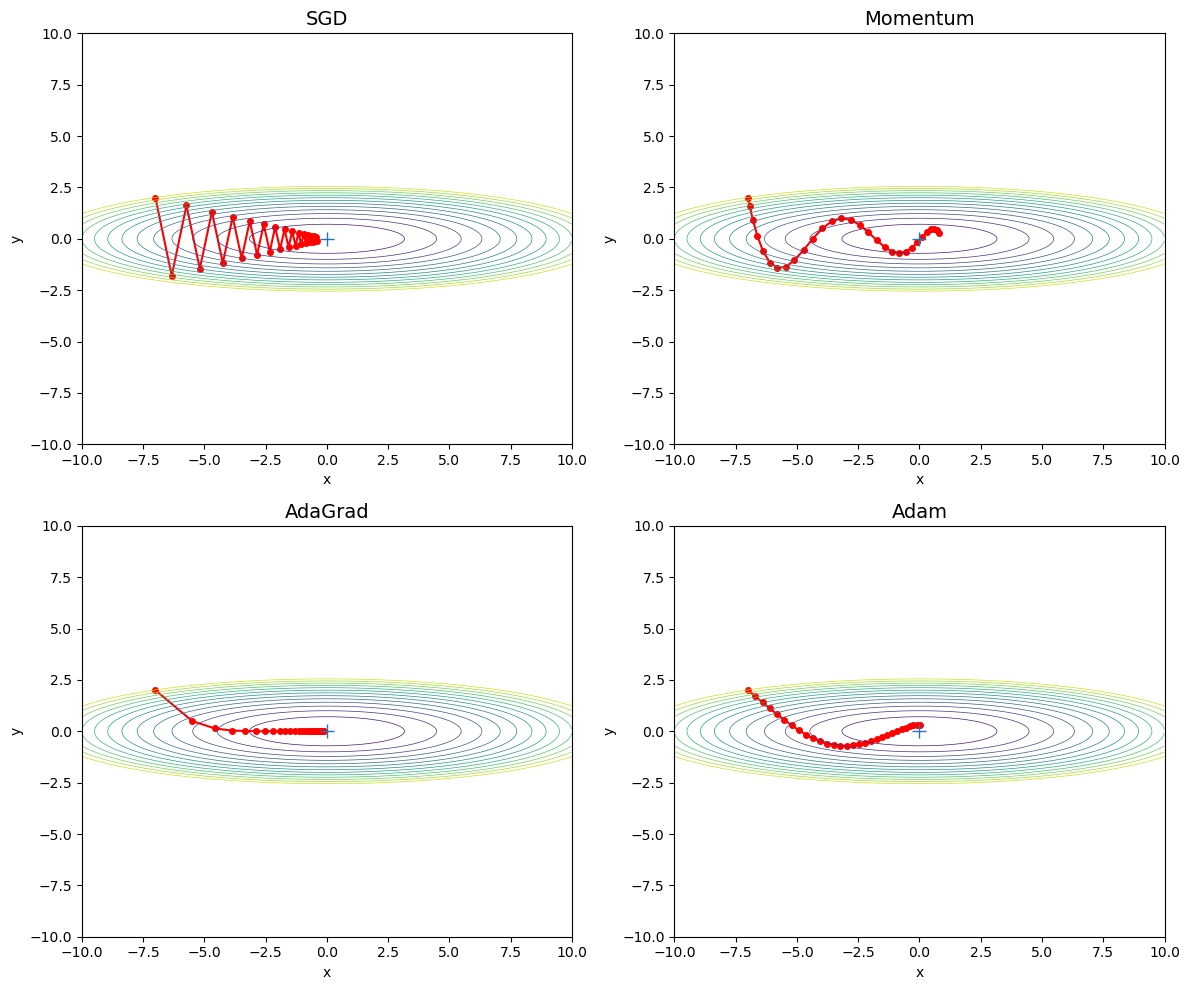

In [5]:
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # bigger figure
axes = axes.flatten()

for idx, (key, optimizer) in enumerate(optimizers.items()):
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    mask = Z > 7
    Z[mask] = np.nan

    ax = axes[idx]
    ax.plot(x_history, y_history, 'o-', color="red", markersize=4)
    ax.contour(X, Y, Z, levels=15, linewidths=0.5)
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)
    ax.plot(0, 0, '+', markersize=10)
    ax.set_title(key, fontsize=14)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

#### 6.1.8 基于MNIST数据集的更新方法的比较
这个实验以一个 5 层神经网络为对象，其中每层有 100 个神经元。激活函数使用的是 ReLU。与 SGD 相比，其他 3 种方法学习得更快，而且速度基本相同，仔细看的话，AdaGrad 的学习进行得稍微快一点。这个实验需要注意的地方是，实验结果会随学习率等超参数、神经网络的结构（几层深等）的不同而发生变化。不过，一般而言，与 SGD 相比，其他 3 种方法可以学习得更快，有时最终的识别精度也更高。

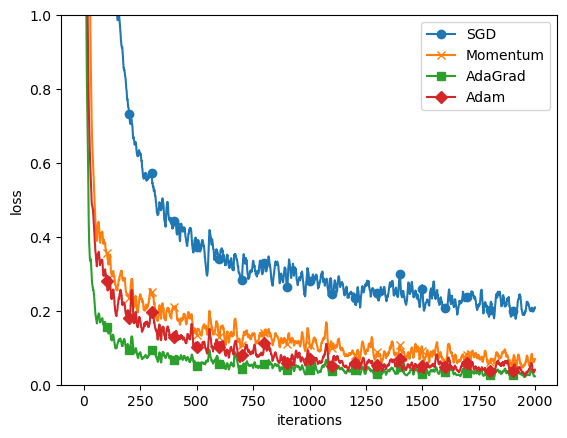

In [6]:
# 此实验运行耗时较长约半分钟
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    # if i % 100 == 0:
    #     print( "===========" + "iteration:" + str(i) + "===========")
    #     for key in optimizers.keys():
    #         loss = networks[key].loss(x_batch, t_batch)
    #         print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 6.2 权重的初始值
- 在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的权重初始值，经常关系到神经网络的学习能否成功。
- 本节将介绍权重初始值的推荐值，并通过实验确认神经网络的学习是否会快速进行。
- 权重初始化说白了就是：让信号传播的时候**别爆炸**也**别消失**。初始化不好，整个网络不是炸梯度，就是梯度扁到和纸一样学不动。
- 初始化的目的不是“随机”，而是“维持方差”, 这是最关键的思想：在多层网络中尽量保持激活值和梯度的**方差一致**，不爆炸、不消失。
- forward pass：保持激活值的**方差不变**; backward pass：保持梯度的**方差不变**.
- 上面6.1节中的优化器决定你**往哪走**，6.2初始化决定你能不能**走得起来**（激活函数决定你应该怎么初始化的方式，why？）。
- 所以6.2节讲的是如何把 W 初始化得刚刚好。

1. Xavier 初始化（适合 Sigmoid / Tanh）- 核心思想：输入输出的方差要一致。
2. He 初始化（适合 ReLU 系列）- 核心逻辑：ReLU 会把一半输入砍掉，所以方差要放大 √2 倍。
3. 数学原理：保持信号在前向/反向传播中的方差稳定

**常见的初始化陷阱：**  
❌ 全零初始化：所有神经元学得一模一样（对称性破坏失败）  
❌ 太大初始化：梯度爆炸/激活函数饱和  
❌ 太小初始化：梯度消失/学习停滞  

```python
def 选择激活函数(场景):
    if 场景 == '隐藏层-现代CNN':
        return 'ReLU'
    elif 场景 == '隐藏层-循环神经网络':
        return 'Tanh'  # 在LSTM/GRU中
    elif 场景 == '输出层-二分类':
        return 'Sigmoid'  
    elif 场景 == '输出层-多分类':
        return 'Softmax'
    elif 场景 == '输出层-回归':
        return '恒等函数'
```

#### 6.2.0 加餐 - “保持方差一致”到底指的是什么方差？为什么重要？
- 保持方差一致 = 保证每一层的信号强度差不多，不会越传越弱，也不会越传越强，即保持每一层的**激活和梯度的强度不变**。
- 方差 = 信号的强度 / 分布的大小。在神经网络中频繁出现三种“方差”：
1. 激活值的方差（forward）
    - 即每一层神经元的**输出分布**有多大。
    - 如果这一层输出非常小（趋近于 0 或常数），下一层几乎没信息可用 → **梯度消失**。
    - 如果这一层输出特别大（漂移到 100、1000），下一层会被巨大的输入撑爆 → **梯度爆炸**。
2. 梯度的方差（backward）反向传播也是一层一层传递梯度。
    - 梯度过小 → 更新不到权重 → “学不会”。
    - 梯度过大 → 权重乱跳 → “学炸了”。
3. 权重乘上输入之后的加权输入值 z 的方差，因为每一层都是：
    - z = W x + b ，a = activation(z)。所以你需要保证：
    - z 的方差不要因为深度而越传越小（消失）
    - z 的方差不要越传越大（爆炸）

#### 6.2.1 可以将权重初始值设为0吗
- 后面我们会介绍抑制过拟合、提高泛化能力的技巧——权值衰减（ weight decay ）。简单地说，权值衰减就是一种以减小权重参数的值为目的进行学习的方法。通过减小权重参数的值来抑制过拟合的发生。
- 将权重初始值设为 0 不是一个好主意。事实上，将权重初始值设为0的话，将无法正确进行学习。
- 为什么不能将权重初始值设成一样的值呢？这是因为在误差反向传播法中，所有的权重值都会进行相同的更新。
- 比如，在 2 层神经网络中，假设第 1 层和第 2 层的权重为 0。这样一来，正向传播时，因为输入层的权重为 0，所以第 2 层的神经元全部会被传递相同的值。第 2 层的神经元中全部输入相同的值，这意味着反向传播时第 2 层的权重全部都会进行相同的更新（乘法节点的反向传播）

#### 6.2.2 Sigmoid的激活值的分布
- 这里要做的实验是，向一个 5 层神经网络（激活函数使用**sigmoid** 函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。
- 各层的激活值的分布都要求有**适当的广度**。为什么呢？因为通过在各层间传递**多样性的数据**，神经网络可以进行**高效的学习**。反过来，如果传递的是有所偏向的数据，就会出现**梯度消失**或者“**表现力受限**”的问题，导致学习可能无法顺利进行。


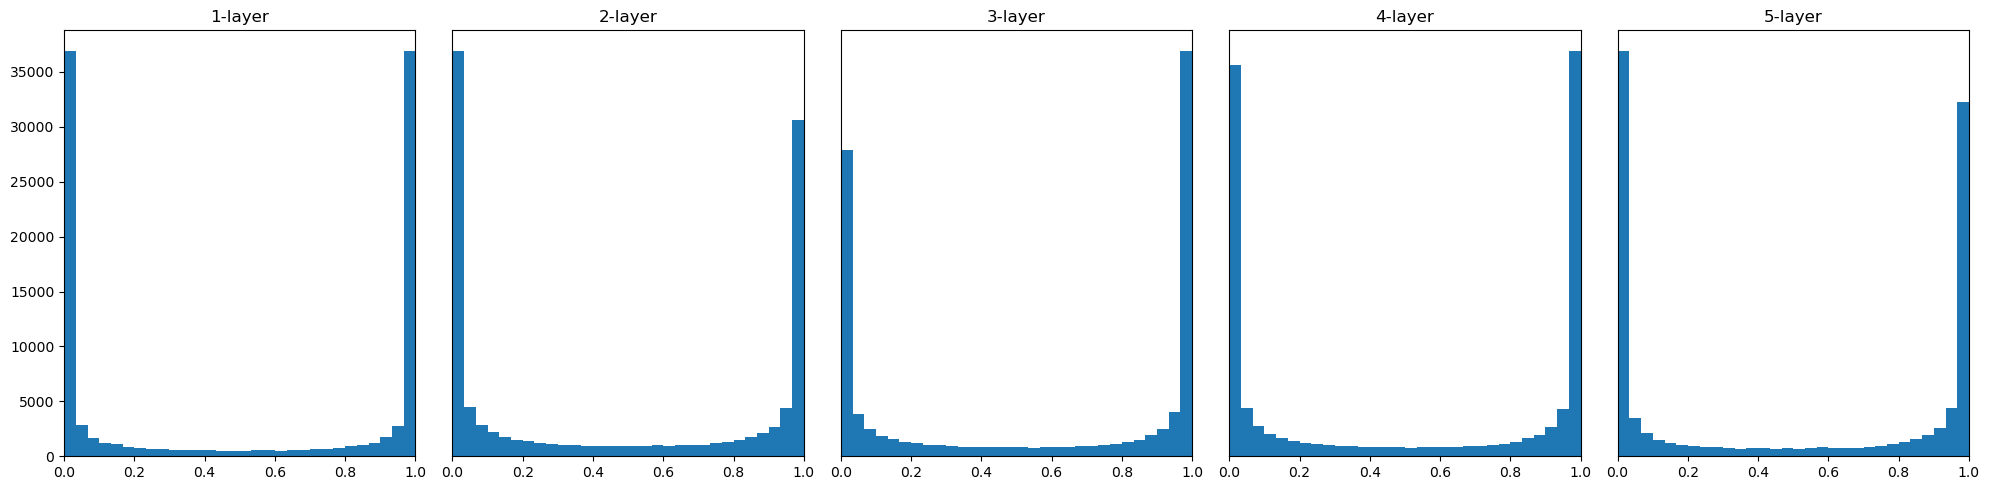

In [7]:
"""
坏实验 1《梯度消失》: 标准差为 * 1，激活函数sigmoid:

从图可知，各层的激活值呈偏向 0 和 1 的分布。这里使用的 sigmoid函数是 S 型函数.
随着输出不断地靠近 0 （或者靠近 1 ），它的导数 y * (1 - y)的值逐渐接近 0。
因此，偏向 0 和 1 的数据分布会造成反向传播中梯度的值不断变小，最后消失。这个问题称为梯度消失(gradient vanishing),
层次加深的深度学习中，梯度消失的问题可能会更加严重。
"""
x = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # 改变激活函数进行实验！
    z = sigmoid(a)
    # z = relu(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
fig, axes = plt.subplots(1, len(activations), figsize=(20, 5))  # 更宽的画布
axes = np.atleast_1d(axes)  # 保证 axes 可索引

for i, a in activations.items():
    ax = axes[i]
    ax.set_title(f"{i+1}-layer", fontsize=12)

    # 画直方图
    ax.hist(a.flatten(), bins=30, range=(0, 1))
    ax.set_xlim(0, 1)

    # 如果不是第一个子图，隐藏 y 轴刻度
    if i != 0:
        ax.set_yticks([])

    # 设置更清晰的 x 轴刻度（0.0,0.2,...,1.0）
    xticks = np.linspace(0, 1, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{v:.1f}" for v in xticks])

plt.tight_layout()
plt.show()

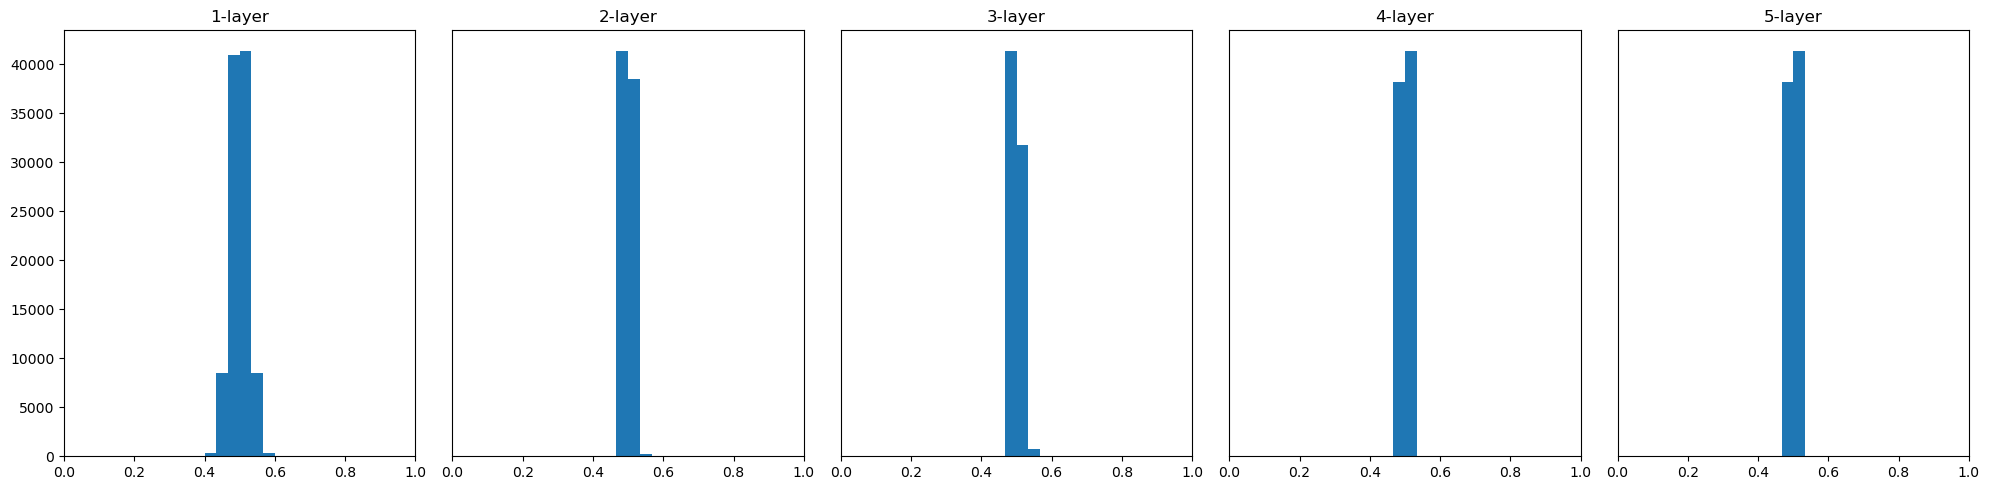

In [8]:
"""
坏实验 2《表现力受限》: 标准差为 * 0.01，激活函数sigmoid:

这次呈集中在 0.5 附近的分布。因为不像刚才的例子那样偏向 0 和 1，所以不会发生梯度消失的问题。
但是，激活值的分布有所偏向，说明在表现力上会有很大问题。为什么这么说呢？因为如果有多个神经元都输出几乎相同的值，那它们就没有存在的意义了。
比如，如果 100 个神经元都输出几乎相同的值，那么也可以由 1 个神经元来表达基本相同的事情。
因此，激活值在分布上有所偏向会出现“表现力受限”的问题。
"""
x = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier + Sigmoid/Tanh
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He + ReLU

    a = np.dot(x, w)

    # 改变激活函数进行实验！
    z = sigmoid(a)
    # z = relu(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
fig, axes = plt.subplots(1, len(activations), figsize=(20, 5))  # 更宽的画布
axes = np.atleast_1d(axes)  # 保证 axes 可索引

for i, a in activations.items():
    ax = axes[i]
    ax.set_title(f"{i+1}-layer", fontsize=12)

    # 画直方图
    ax.hist(a.flatten(), bins=30, range=(0, 1))
    ax.set_xlim(0, 1)

    # 如果不是第一个子图，隐藏 y 轴刻度
    if i != 0:
        ax.set_yticks([])

    # 设置更清晰的 x 轴刻度（0.0,0.2,...,1.0）
    xticks = np.linspace(0, 1, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{v:.1f}" for v in xticks])

plt.tight_layout()
plt.show()

- **Xavier**初始值：与前一层有 n 个节点连接时，初始值使用标准差为$\sqrt{\frac{1}{n}}$ 的分布. 
- 使用 Xavier 初始值后，前一层的**节点数越多**，要设定为目标节点的初始值的**权重尺度就越小**。

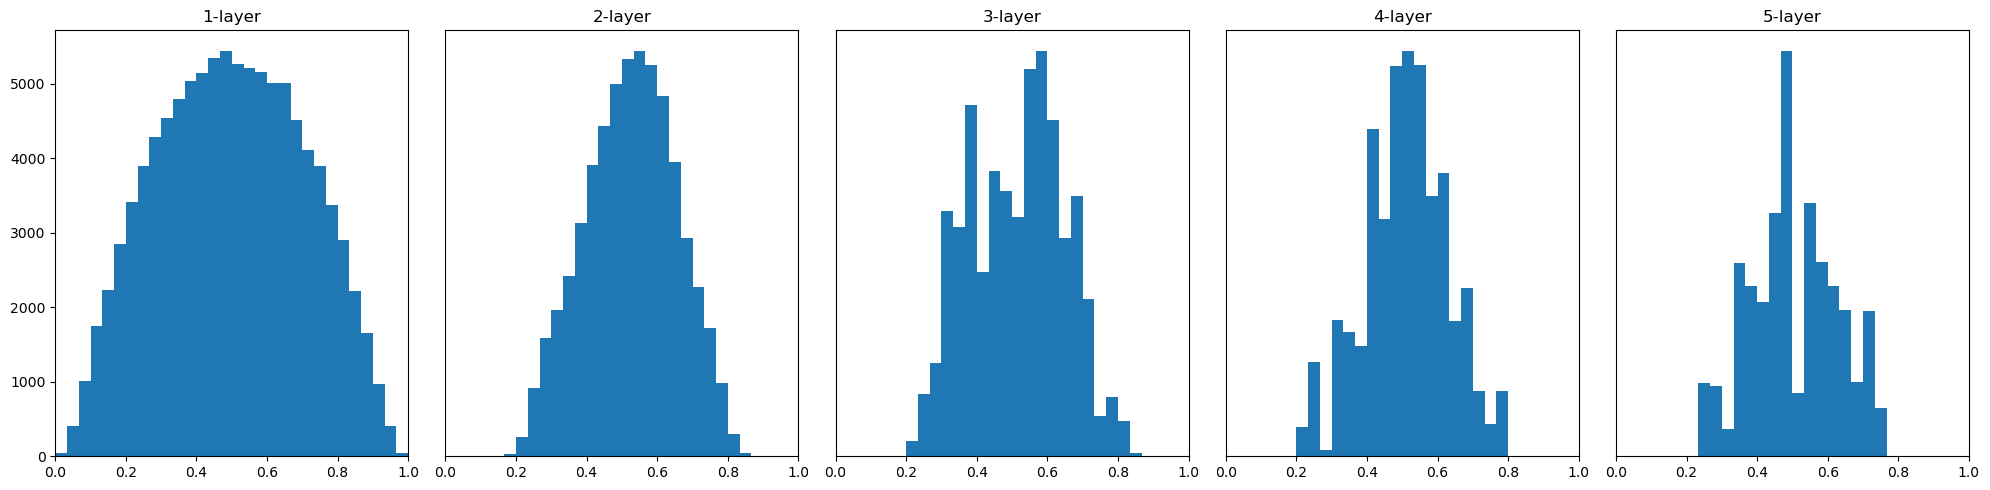

In [9]:
"""
好实验 3《Xavier初始值》: 标准差为 * np.sqrt(1.0 / node_num)，激活函数sigmoid:

使用 Xavier 初始值后的结果可知，越是后面的层，图像变得越歪斜，但是呈现了比之前更有广度的分布。
因为各层间传递的数据有适当的广度，所以 sigmoid 函数的表现力不受限制，有望进行高效的学习。
"""
x = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier + Sigmoid/Tanh
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He + ReLU

    a = np.dot(x, w)

    # 改变激活函数进行实验！
    z = sigmoid(a)
    # z = relu(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
fig, axes = plt.subplots(1, len(activations), figsize=(20, 5))  # 更宽的画布
axes = np.atleast_1d(axes)  # 保证 axes 可索引

for i, a in activations.items():
    ax = axes[i]
    ax.set_title(f"{i+1}-layer", fontsize=12)

    # 画直方图
    ax.hist(a.flatten(), bins=30, range=(0, 1))
    ax.set_xlim(0, 1)

    # 如果不是第一个子图，隐藏 y 轴刻度
    if i != 0:
        ax.set_yticks([])

    # 设置更清晰的 x 轴刻度（0.0,0.2,...,1.0）
    xticks = np.linspace(0, 1, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{v:.1f}" for v in xticks])

plt.tight_layout()
plt.show()

#### 6.2.3 ReLU的权重初始值
- Xavier 初始值是以激活函数是**线性函数**为前提而推导出来的。因为**sigmoid和tanh函数左右对称，且中央附近可以视作线性函数，所以适用Xavier。
- **He** 初始值使用标准差为 $\sqrt{\frac{2}{n}}$ 的高斯分布, 因为**ReLU**的负值区域的值为 0，为了使它更有广度，所以需要 2 倍的系数。

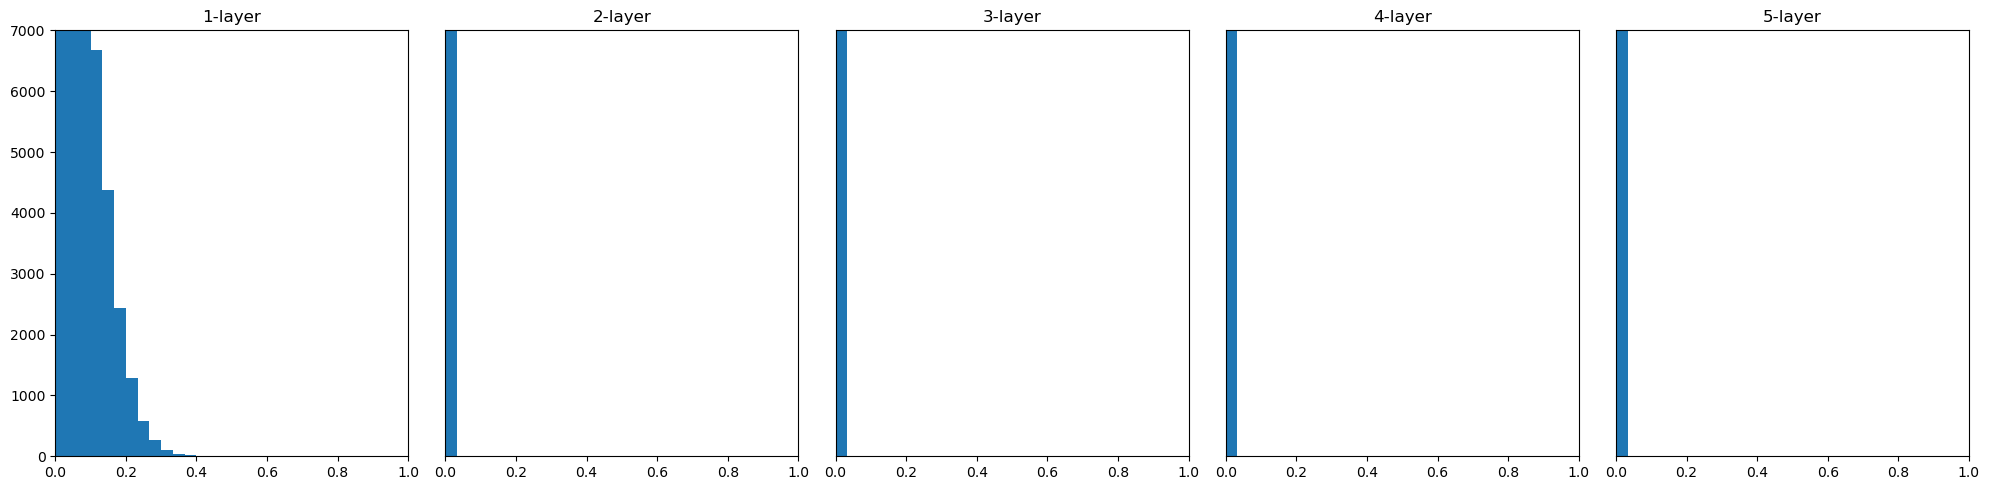

In [10]:
"""
坏实验 4《各层的激活值非常小》: 标准差为 * 0.01，激活函数ReLU:

观察实验结果可知，当“std = 0.01”时，各层的激活值非常小。
神经网络上传递的是非常小的值，说明逆向传播时权重的梯度也同样很小。
这是很严重的问题，实际上学习基本上没有进展。
"""
x = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier + Sigmoid/Tanh
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He + ReLU

    a = np.dot(x, w)

    # 改变激活函数进行实验！
    # z = sigmoid(a)
    z = relu(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
fig, axes = plt.subplots(1, len(activations), figsize=(20, 5))  # 更宽的画布
axes = np.atleast_1d(axes)  # 保证 axes 可索引

for i, a in activations.items():
    ax = axes[i]
    ax.set_title(f"{i+1}-layer", fontsize=12)

    # 画直方图
    ax.hist(a.flatten(), bins=30, range=(0, 1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 7000)

    # 如果不是第一个子图，隐藏 y 轴刻度
    if i != 0:
        ax.set_yticks([])

    # 设置更清晰的 x 轴刻度（0.0,0.2,...,1.0）
    xticks = np.linspace(0, 1, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{v:.1f}" for v in xticks])

plt.tight_layout()
plt.show()

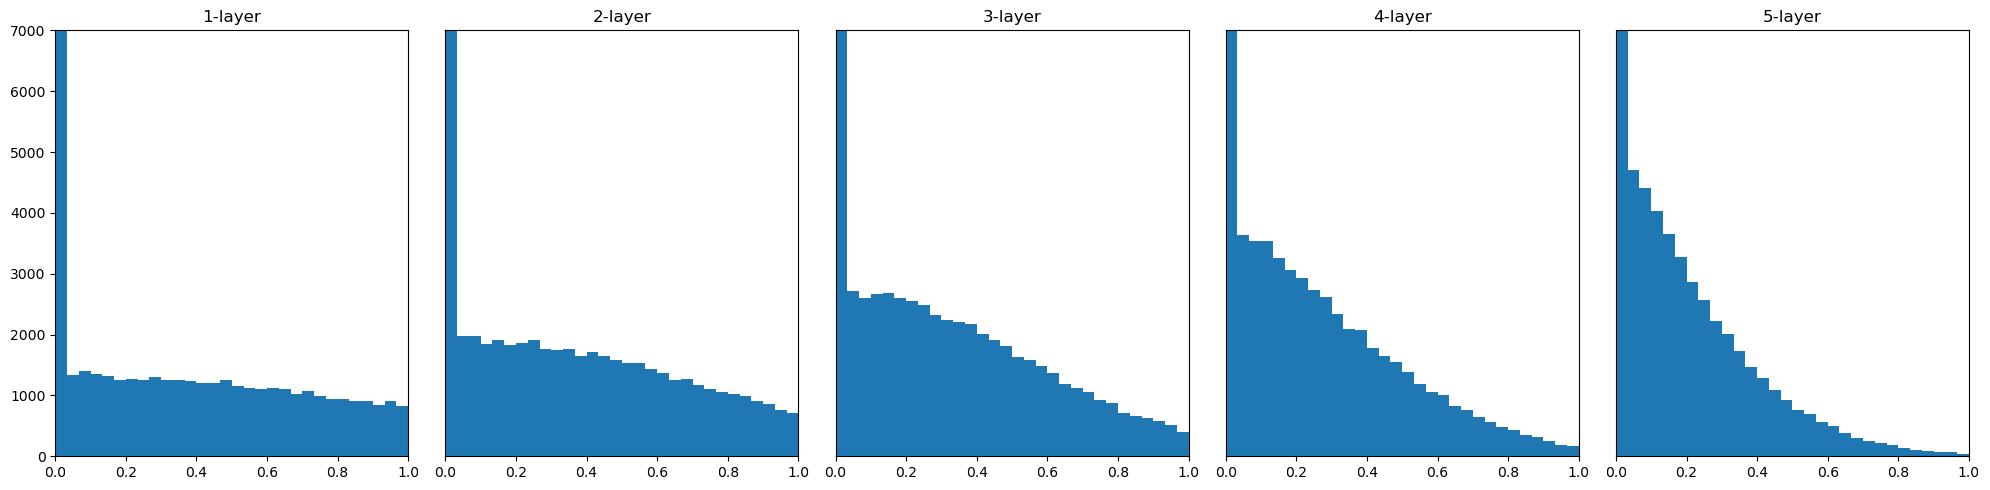

In [11]:
"""
坏实验 5《Xavier初始值》: 标准差为 * np.sqrt(1.0 / node_num)，激活函数ReLU:

接下来是初始值为 Xavier 初始值时的结果。在这种情况下，随着层的加深，
偏向一点点变大。实际上，层加深后，激活值的偏向变大，学习时会出现梯度消失的问题。
"""
x = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier + Sigmoid/Tanh
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He + ReLU

    a = np.dot(x, w)

    # 改变激活函数进行实验！
    # z = sigmoid(a)
    z = relu(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
fig, axes = plt.subplots(1, len(activations), figsize=(20, 5))  # 更宽的画布
axes = np.atleast_1d(axes)  # 保证 axes 可索引

for i, a in activations.items():
    ax = axes[i]
    ax.set_title(f"{i+1}-layer", fontsize=12)

    # 画直方图
    ax.hist(a.flatten(), bins=30, range=(0, 1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 7000)

    # 如果不是第一个子图，隐藏 y 轴刻度
    if i != 0:
        ax.set_yticks([])

    # 设置更清晰的 x 轴刻度（0.0,0.2,...,1.0）
    xticks = np.linspace(0, 1, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{v:.1f}" for v in xticks])

plt.tight_layout()
plt.show()

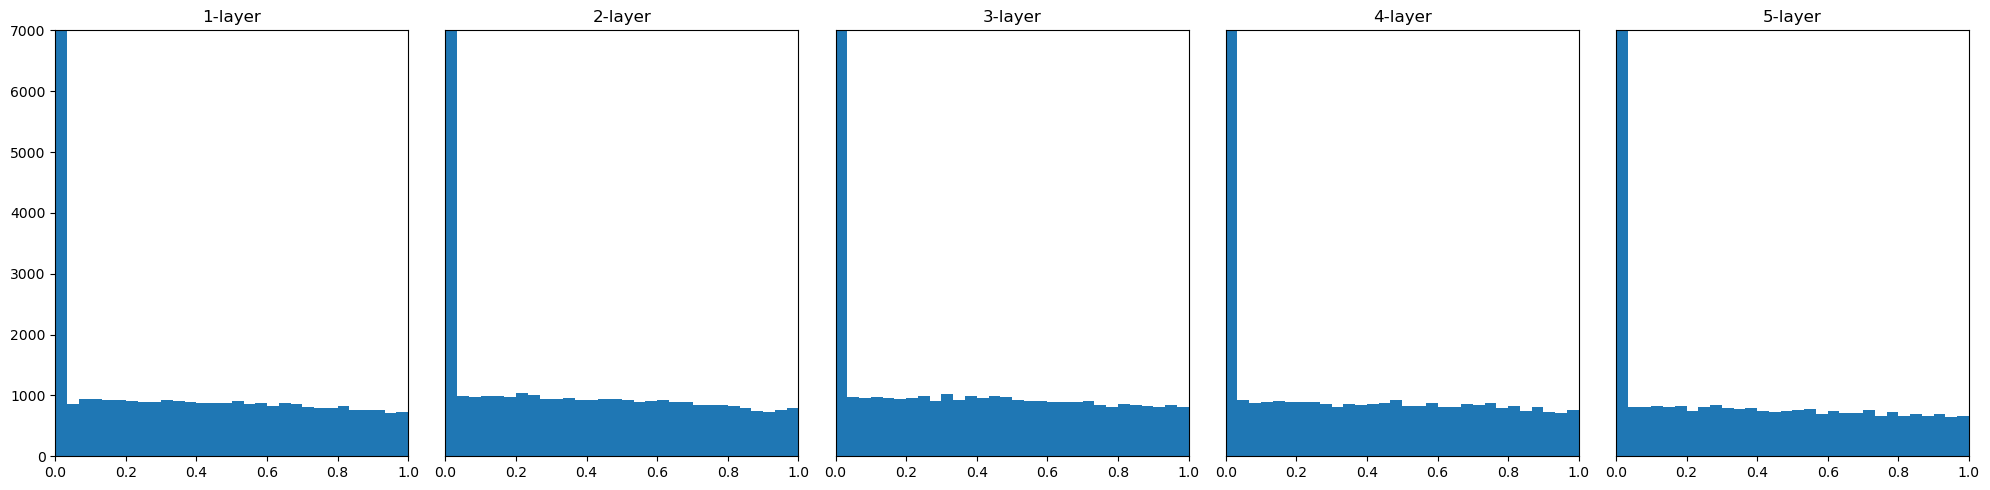

In [12]:
"""
好实验 6《He初始值》: 标准差为 * np.sqrt(2.0 / node_num)，激活函数ReLU:

He 初始值时，各层中分布的广度相同。由于即便层加深，数据的广度也能保持不变，因此逆向传播时，也会传递合适的值。
激活函数使用 ReLU 时，权重初始值使用 He 初始值; 当激活函数为 sigmoid或 tanh等 S 型曲线函数时，初始值使用 Xavier 初始值。
"""
x = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier + Sigmoid/Tanh
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He + ReLU

    a = np.dot(x, w)

    # 改变激活函数进行实验！
    # z = sigmoid(a)
    z = relu(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
fig, axes = plt.subplots(1, len(activations), figsize=(20, 5))  # 更宽的画布
axes = np.atleast_1d(axes)  # 保证 axes 可索引

for i, a in activations.items():
    ax = axes[i]
    ax.set_title(f"{i+1}-layer", fontsize=12)

    # 画直方图
    ax.hist(a.flatten(), bins=30, range=(0, 1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 7000)

    # 如果不是第一个子图，隐藏 y 轴刻度
    if i != 0:
        ax.set_yticks([])

    # 设置更清晰的 x 轴刻度（0.0,0.2,...,1.0）
    xticks = np.linspace(0, 1, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{v:.1f}" for v in xticks])

plt.tight_layout()
plt.show()

#### 6.2.4 基于MNIST数据集的权重初始值的比较

===========iteration:0 loss value===========
std=0.01:2.3024759417630962
Xavier:2.300681730376668
He:2.31954121172811
===========iteration:400 loss value===========
std=0.01:2.299487281645278
Xavier:1.648287293892487
He:0.38688818495677957
===========iteration:800 loss value===========
std=0.01:2.303839042104725
Xavier:0.4633782649969718
He:0.24475979342895848
===========iteration:1200 loss value===========
std=0.01:2.3012090923404034
Xavier:0.5444565328030724
He:0.42317260746779534
===========iteration:1600 loss value===========
std=0.01:2.2983247881868163
Xavier:0.2346849207885341
He:0.1296125017306751
===========iteration:1999 loss value===========
std=0.01:2.302878561969176
Xavier:0.19834762201498896
He:0.14747229854562044


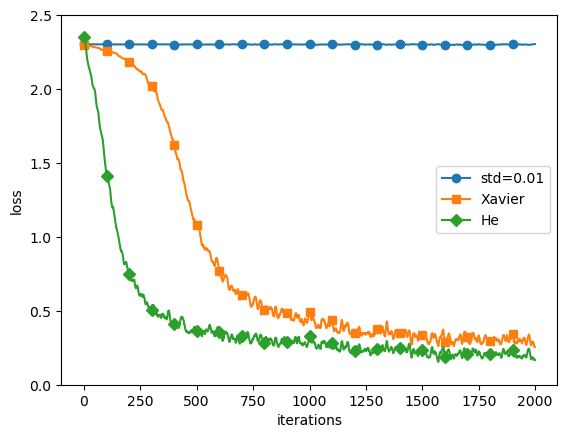

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 400 == 0 or i+1 == max_iterations:
        print("===========" + "iteration:" + str(i) + " loss value===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

- 观察不同的权重初始值的赋值方法会在多大程度上影响神经网络的学习。这里，我们基于 std = 0.01、Xavier 初始值、He 初始值进行实验.
- 这个实验中，神经网络有 5 层，每层有 100 个神经元，激活函数使用的是 ReLU。从图的结果可知，std = 0.01 时完全无法进行学习。
- 这和刚才观察到的激活值的分布一样，因为正向传播中传递的值很小（集中在0附近的数据）。因此，逆向传播时的梯度也很小，权重几乎不进行更新。
- 相反，当权重初始值为 Xavier 初始值和 He 初始值时，学习进行得很顺利。并且，我们发现 He 初始值时的学习进度更快一些。
- 对比**第五章TwoLayerNet**，因为它网络太浅只有一层使用ReLU、信号只要穿过一次std=0.01权重缩放，小权重还能活下来。

### 6.3 Batch Normalization
Batch Norm 有以下优点:
- 可以使学习快速进行（可以增大学习率）。
- 不那么依赖初始值（对于初始值不用那么神经质）。
- 抑制过拟合（降低 Dropout 等的必要性）。

Batch Norm，顾名思义，以进行学习时的 mini-batch 为单位，按 mini-batch 进行正规化。具体而言，就是进行使数据分布的均值为 0、方差为 1 （合适的分布）的正规化, 可以减小数据分布的偏向。在上一节，我们观察了各层的激活值分布，并从中了解到如果设定了合适的**权重初始值**，则各层的*激活值*分布会有**适当的广度**，从而可以顺利地进行学习。那么，为了使各层拥有适当的广度，“强制性”地调整激活值的分布会怎样呢？实际上，Batch Normalization (Batch Norm 批归一化/标准化) 方法就是基于这个想法而产生的。Batch Norm 的思路是调整各层的**激活值分布**使其拥有适当的广度。为此，要向神经网络中插入对数据分布进行正规化 + 数据缩放&平移变换的Batch Norm**层**:  
- InputLayer → [Affine1 → **BatchNorm1** → Relu1] → [Affine2 → **BatchNorm2** → Relu2] → Affine3 → Softmax →    

✅ 均值 = 总和 / 数量  
$$\mu_B \leftarrow \frac{1}{m}\sum\limits_{i=1}^m x_i (B=mini Batch) - 等同于 \mu = \frac{x_1 + x_2 + x_3 + ... + x_n}{n}$$
✅ 方差 = 平方差的平均值  
$$ \sigma^2_B \leftarrow \frac{1}{m} \sum\limits_{i=1}^m (x_i - \mu_B)^2 - 等同于 \sigma^2 = \frac{(x_1 - \mu)^2 + (x_2 - \mu)^2 + ... + (x_n - \mu)^2}{n}$$
✅ 标准差 = 方差的平方根  
$$ \sigma = \sqrt{\sigma^2} $$
✅ Batch Norm - 数据标准化为均值为0，方差为1
$$ \hat{x}_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \varepsilon}} (\varepsilon=1e-7) - 等同于 X_{standardized} = \frac{X - \mu}{\sigma}$$
✅ 数据**缩放**和**平移**的变换
$$ y_i \leftarrow \gamma \hat{x}_i + \beta (γ 和 β 是参数。一开始 γ= 1，β= 0，然后再通过学习调整到合适的值) $$

```python
# 神经网络权重初始化, 常见的He初始化（适合ReLU激活函数）
weights = np.random.randn(10, 5) * np.sqrt(2.0 / 10)

# 数据标准化, 训练前标准化输入数据
x_train_standardized = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
```

In [14]:
def standardize(data):
    """将数据标准化为均值为0，方差为1"""
    return (data - np.mean(data)) / np.std(data) # (数据 - 均值) / 标准差

# 方法2：使用 scikit-learn
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# standardized_data = scaler.fit_transform(original_data.reshape(-1, 1)).flatten()

# 示例：任意数据
original_data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
standardized_data = standardize(original_data)

print(f"原始数据: {original_data}")
print(f"原始均值: {original_data.mean():.4f}")
print(f"原始方差: {original_data.var():.4f}")
print(f"原始标差: {original_data.std():.4f}")
print("========================================")
print(f"标准化后数据: {standardized_data}")
print(f"标准化后均值: {standardized_data.mean():.4f}")  # 0.0000
print(f"标准化后方差: {standardized_data.var():.4f}")   # 1.0000
print(f"标准化后标差: {standardized_data.std():.4f}")   # 1.0000

原始数据: [ 10  20  30  40  50  60  70  80  90 100]
原始均值: 55.0000
原始方差: 825.0000
原始标差: 28.7228
标准化后数据: [-1.5666989  -1.21854359 -0.87038828 -0.52223297 -0.17407766  0.17407766
  0.52223297  0.87038828  1.21854359  1.5666989 ]
标准化后均值: -0.0000
标准化后方差: 1.0000
标准化后标差: 1.0000


#### 6.3.2 Batch Normalization的评估
我们发现，几乎所有的情况下都是使用 Batch Norm 时学习进行得更快。同时也可以发现，实际上，在不使用 Batch Norm 的情况下，如果不赋予一个尺度好的初始值，学习将完全无法进行。综上，通过使用 Batch Norm，可以推动学习的进行。并且，对权重初始值变得健壮（“对初始值健壮”表示不那么依赖初始值）。Batch Norm 具备了如此优良的性质，一定能应用在更多场合中。

### 6.4 正则化
机器学习的问题中，**过拟合**是一个很常见的问题。过拟合指的是只能拟合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。机器学习的目标是提高**泛化能力**，即便是没有包含在训练数据里的**未观测数据**，也希望模型可以进行正确的识别。

#### 6.4.1 过拟合, 
- 原因:
    - 模型拥有大量参数、表现力强。
    - 训练数据少。
- 实验
    - 这里，我们故意满足这两个条件，制造过拟合现象。为此，要从MNIST 数据集原本的 60000 个训练数据中只选定 300 个，并且，为了增加网络的复杂度，使用 7 层网络（每层有 100 个神经元，激活函数为 ReLU ）。
    - 过了100个epoch左右后，用训练数据测量到的识别精度几乎都为100%。但是，对于测试数据，离 100% 的识别精度还有较大的差距。如此大的识别精度差距，是只拟合了训练数据的结果。从图中可知，模型对训练时没有使用的一般数据（测试数据）拟合得不是很好。

#### 6.4.2 权值衰减
- 权值衰减是一直以来经常被使用的一种**抑制过拟合**的方法。该方法通过在学习的过程中对**大的权重**进行惩罚，来抑制过拟合。很多过拟合原本就是因为**权重参数取值过大**才发生的。
- 神经网络的学习目的是减小损失函数的值。这时，例如为损失函数加上权重的平方范数（ L2 范数）。这样一来，就可以抑制权重变大。用符号表示的话，如果将权重记为 W，L2 范数的权值衰减就是$\frac{1}{2}\lambda W^2$, 然后将这个$\frac{1}{2}\lambda W^2$加到损失函数上。这里，$\lambda$是控制正则化强度的超参数。$\lambda$设置得越大，对大的权重施加的惩罚就越重。此外，$\frac{1}{2}\lambda W^2$开头的$\frac{1}{2}$是用于将求导结果变成 λW 的调整用常量。对于所有权重，权值衰减方法都会为损失函数加上$\frac{1}{2}\lambda W^2$因此，在求权重梯度的计算中，要为之前的误差反向传播法的结果加上正则化项的导数λW。
- 如图所示，虽然训练数据的识别精度和测试数据的识别精度之间有差距，但是与没有使用权值衰减的图 6-20 的结果相比，差距变小了。这说明过拟合受到了抑制。此外，还要注意，训练数据的识别精度没有达到 100% （ 1.0 ）。

#### 6.4.3 Dropout
- 抑制过拟合的权值衰减方法，该方法可以简单地实现，在某种程度上能够抑制过拟合。但是，如果网络的模型变得很**复杂**，只用权值衰减就难以应对了。在这种情
况下，我们经常会使用 Dropout 方法。
- Dropout 是一种在学习的过程中**随机删除神经元**的方法。训练时，随机选出隐藏层的神经元，然后将其删除。被删除的神经元不再进行信号的传递，**训练时**，每传递一次数据，就会随机选择要删除的神经元。然后，**测试时**，虽然会传递所有的神经元信号，但是对于各个神经元的输出，要**乘上**训练时的**删除比例**后再输出。
- 下面我们来实现 Dropout。这里的实现重视易理解性。不过，因为训练时如果进行恰当的计算的话，正向传播时单纯地传递数据就可以了（不用乘以删除比例），所以深度学习的框架中进行了这样的实现。这里的要点是，每次正向传播时，self.mask中都会以 False的形式保存要删除的神经元。self.mask会随机生成和 x形状相同的数组，并将值比dropout_ratio大的元素设为 True。反向传播时的行为和 ReLU 相同。也就是说，正向传播时传递了信号的神经元，反向传播时按原样传递信号；正向传播时没有传递信号的神经元，反向传播时信号将停在那里。

In [15]:
class Dropout:

    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

我们使用 MNIST 数据集进行验证，以确认 Dropout 的效果。Dropout 的实验和前面的实验一样，使用 7 层网络（每层有 100 个神经元，激活函数为 ReLU ），一个使用 Dropout，另一个不使用 Dropout，通过使用 Dropout，训练数据和测试数据的识别精度的差距变小了。并且，训练数据也没有到达 100% 的识别精度。像这样，通过使用Dropout，即便是表现力强的网络，也可以抑制过拟合。

### 6.5 超参数的验证
神经网络中，除了权重和偏置等参数，超参数 （ hyper-parameter ）也经常出现。这里所说的超参数是指，比如各层的**神经元数量**、**batch 大小**、参数更新时的**学习率**或**权值衰减**等。如果这些超参数没有设置合适的值，模型的性能就会很差。虽然超参数的取值非常重要，但是在决定超参数的过程中一般会伴随很多的**试错**。本节将介绍尽可能高效地寻找超参数的值的方法。

#### 6.5.1 验证数据
- 数据集分成了《训练数据》《测试数据》- 练数据用于学习，测试数据用于评估泛化能力和是否过拟合。不能使用**测试数据**评估超参数的性能，为什么，因为如果使用测试数据调整超参数，超参数的值会对测试数据发生过拟合。
- 换句话说，用测试数据确认超参数的值的“好坏”，就会导致超参数的值被调整为只拟合测试数据，可能就会得到不能拟合其他数据、泛化能力低的模型。
- 因此，调整超参数时，必须使用超参数专用的确认数据。用于调整超参数的数据，一般称为验证数据 （ validation data ）。  
    - 训练数据：用于参数（权重和偏置）的学习。
    - 验证数据：用于超参数的性能评估。
    - 测试数据：为了确认泛化能力，要在最后使用（比较理想的是只用一次）。
- 根据不同的数据集，有的会事先分成训练数据、验证数据、测试数据三部分，有的只分成训练数据和测试数据两部分，有的则不进行分割。在这种情况下，用户需要自行进行分割。如果是 MNIST 数据集，获得验证数据的最简单的方法就是从训练数据中事先分割 20% 作为验证数据，代码如下所示。

In [16]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()
# 打乱训练数据
x_train, t_train = shuffle_dataset(x_train, t_train)
# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]
print(len(x_val), len(t_val), len(x_train), len(t_train))

12000 12000 48000 48000


#### 6.5.2 超参数的最优化
- 我们使用**验证数据**观察超参数的最优化方法, 进行超参数的最优化时，逐渐缩小超参数的“好值”的存在范围非常重要。所谓逐渐缩小范围，是指一开始先大致设定一个范围，从这个范围中随机选出一个超参数（采样），用这个采样到的值进行识别精度的评估；然后，多次重复该操作，观察识别精度的结果，根据这个结果缩小超参数的“好值”的范围。通过重复这一操作，就可以逐渐确定超参数的合适范围。
- 超参数的范围只要“大致地指定”就可以了。所谓“大致地指定”，是指像 0.001（$10^{-3}$）到 1000（{10^3}）这样，以“10 的阶乘”的尺度指定范围.
- 在超参数的最优化中，要注意的是深度学习需要很长时间（比如，几天或几周）。因此，在超参数的搜索中，需要尽早放弃那些不符合逻辑的超参数。
- 于是，在超参数的最优化中，减少学习的 epoch，缩短一次评估所需的时间是一个不错的办法。  

以上就是超参数的最优化的内容，反复进行上述操作，不断缩小超参数的范围，在缩小到一定程度时，从该范围中选出一个超参数的值。这就是进行超参数的最优化的一种方法。步骤总结如下所示:  
1. 设定超参数的范围。
2. 从设定的超参数范围中随机采样。
3. 使用步骤 1 中采样到的超参数的值进行学习，通过验证数据评估识别精度（但是要将 epoch 设置得很小）。
4. 重复步骤 2 和步骤 3 （ 100 次等），根据它们的识别精度的结果，缩小超参数的范围。

#### 6.5.3 超参数最优化的实现
- 使用 MNIST 数据集进行超参数的最优化。这里我们将**学习率**和控制**权值衰减**强度的系数（下文称为“权值衰减系数”）这两个超参数的搜索问题作为对象。
- 通过从 0.001 到 1000 这样的对数尺度的范围中随机采样进行超参数的验证。 python: 10 ** np.random.uniform(-3, 3)。
- 在该实验中，权值衰减系数的初始范围为 $10^{−8}$ 到 $10^{−4}$，学习率的初始范围为 $10^{−6}$ 到 $10^{−2}$。此时，超参数的随机采样的代码如下所示。
- weight_decay = 10 ** np.random.uniform(-8, -4) ; lr = 10 ** np.random.uniform(-6, -2)
- 像这样进行随机采样后，再使用那些值进行学习。之后，多次使用各种超参数的值重复进行学习，观察合乎逻辑的超参数在哪里。

### 6.6 小结
本章我们介绍了神经网络的学习中的几个重要技巧。参数的更新方法、权重初始值的赋值方法、Batch Normalization、Dropout 等，这些都是现代神经网络中不可或缺的技术。另外，这里介绍的技巧，在最先进的深度学习中也被频繁使用。
- 参数的更新方法，除了SGD之外，还有 Momentum、AdaGrad、Adam 等方法。
- 权重初始值的赋值方法对进行正确的学习非常重要。
- 作为权重初始值，Xavier 初始值、He 初始值等比较有效。
- 通过使用 Batch Normalization，可以加速学习，并且对初始值变得健壮。
- 抑制过拟合的正则化技术有权值衰减、Dropout 等。
- 逐渐缩小“好值”存在的范围是搜索超参数的一个有效方法。